In [1]:
import qutip
import numpy as np
from matplotlib import pyplot as plt
import scqubits
# %matplotlib widget

# 1 Define subsystem and hilbertspace

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\varphi$', ylabel='Re $\\psi_j(\\varphi)$,  energy [GHz]'>)

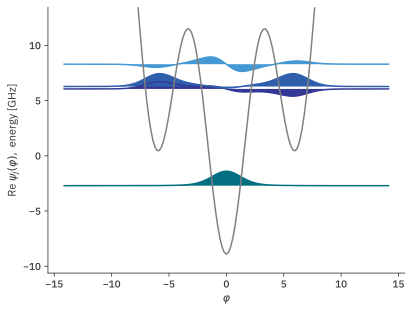

In [2]:
fluxonium = scqubits.Fluxonium(EJ = 8.9,
                               EC = 2.5,
                               EL = 0.5,
                               flux = 0,
                               cutoff = 110)

osc = scqubits.Oscillator(
    E_osc=5.0,
    l_osc = 1,
    truncated_dim=8
)
hilbertspace = scqubits.HilbertSpace([fluxonium, osc])

hilbertspace.add_interaction(
    g_strength=1, op1=fluxonium.n_operator, op2=osc.creation_operator, add_hc=True
)

# Precompute eigensystem to save later computation
hilbertspace.generate_lookup()

fluxonium.plot_wavefunction(which = [0,1,2,3])

# 2 Truncate the hamiltonian

In [3]:
(evals,) = hilbertspace["evals"]
diag_dressed_hamiltonian = (
        2 * np.pi * qutip.Qobj(np.diag(evals),
        dims=[hilbertspace.subsystem_dims] * 2)
)
def truncate(operator: qutip.Qobj, dimension: int) -> qutip.Qobj:
    return qutip.Qobj(operator[:dimension, :dimension])
total_truncation = 30
diag_dressed_hamiltonian_trunc = truncate(diag_dressed_hamiltonian, total_truncation)


# 2 add drive term

In [4]:
def transition_frequency(s0: int, s1: int) -> float:
    assert type(s0) == int, 'bad input'
    assert type(s1) == int, 'bad input'
    return (
        (
            hilbertspace.energy_by_dressed_index(s1)
            - hilbertspace.energy_by_dressed_index(s0)
        )
        * 2 * np.pi
    )

omega_g0g1 = transition_frequency(hilbertspace.dressed_index((0,0)), hilbertspace.dressed_index((0,1)))

A = 0.03 # GHz
tg = 58 # ns

#cos pulse
def drive_coeff(t: float, *args: dict) -> float:
    # exp_part = np.exp(-8 * t * (t - tg) / tg**2)
    cos_part = np.cos(omega_g0g1 * t)
    return A * cos_part
    # return A * exp_part * cos_part

a = hilbertspace.op_in_dressed_eigenbasis(op=osc.annihilation_operator)
a = truncate(a, total_truncation)

H_with_drive = [
    diag_dressed_hamiltonian_trunc,
    [2 * np.pi * (a+a.dag()) , drive_coeff],  # driving through the resonator
]


In [5]:
product_states = [(0, 0), (1, 0), (2,0), (0, 1), (1, 1), (2,1),(0,2)]
idxs = [hilbertspace.dressed_index((s1, s2)) for (s1, s2) in product_states]
qutip_states = [qutip.basis(total_truncation, idx) for idx in idxs]

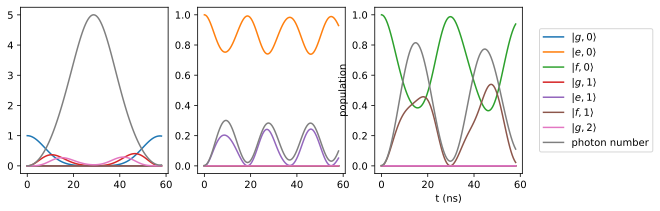

In [6]:
tlist = np.linspace(0, tg, tg*2)

result00 = qutip.sesolve(
    H = H_with_drive,
    psi0 = qutip.basis(total_truncation, hilbertspace.dressed_index((0,0))),
    tlist = tlist,
    e_ops=[state * state.dag() for state in qutip_states]+[a.dag()*a],
    options=qutip.Options(store_final_state=True)
)
result10 = qutip.sesolve(
    H = H_with_drive,
    psi0 = qutip.basis(total_truncation, hilbertspace.dressed_index((1,0))),
    tlist = tlist,
    e_ops=[state * state.dag() for state in qutip_states]+[a.dag()*a],
    options=qutip.Options(store_final_state=True)

)
result20 = qutip.sesolve(
    H = H_with_drive,
    psi0 = qutip.basis(total_truncation, hilbertspace.dressed_index((2,0))),
    tlist = tlist,
    e_ops=[state * state.dag() for state in qutip_states]+[a.dag()*a],
    options=qutip.Options(store_final_state=True)

)

dictionary = {0: 'g', 1: 'e', 2: 'f', 3: 'h'}


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))


for idx, res in zip(idxs, result00.expect):
    product_state = product_states[idxs.index(idx)]
    qubit_state = dictionary[product_state[0]]
    resonator_state = product_state[1]
    ax1.plot(tlist, res, label=r"$|%s\rangle$" % (str(",".join([qubit_state,str(resonator_state)]))))

for idx, res in zip(idxs, result10.expect):
    product_state = product_states[idxs.index(idx)]
    qubit_state = dictionary[product_state[0]]
    resonator_state = product_state[1]
    ax2.plot(tlist, res, label=r"$|%s\rangle$" % (str(",".join([qubit_state,str(resonator_state)]))))
for idx, res in zip(idxs, result20.expect):
    product_state = product_states[idxs.index(idx)]
    qubit_state = dictionary[product_state[0]]
    resonator_state = product_state[1]
    ax3.plot(tlist, res, label=r"$|%s\rangle$" % (str(",".join([qubit_state,str(resonator_state)]))))

ax1.plot(tlist, result00.expect[-1], label=r"photon number")
ax2.plot(tlist, result10.expect[-1], label=r"photon number")
ax3.plot(tlist, result20.expect[-1], label=r"photon number")

ax3.legend(loc='center', ncol=1, bbox_to_anchor=(1.5, 0.5))
plt.ylabel("population")
plt.xlabel("t (ns)")
# plt.yscale('log')
plt.show()

In [37]:
final_00 = result00.final_state
final_10 = result10.final_state
final_20 = result20.final_state

# Next, need to trace out the resonator state

In [38]:
num_levels = final_00.shape[0]
qubit_levels = 0
osc_levels = 0
for level in range(num_levels):
    (ql,ol) = hilbertspace.bare_index(level)
    if ql+1 > qubit_levels:
        qubit_levels = ql+1
    if ol+1 > osc_levels:
        osc_levels = ol+1

qutip_product_state00 = qutip.Qobj(dims = [[qubit_levels,osc_levels],[1,1]])
qutip_product_state10 = qutip.Qobj(dims = [[qubit_levels,osc_levels],[1,1]])
qutip_product_state20 = qutip.Qobj(dims = [[qubit_levels,osc_levels],[1,1]])

for level in range(num_levels):
    (ql,ol) = hilbertspace.bare_index(level)
    qutip_product_state00 += complex(final_00[level]) * qutip.tensor(qutip.basis(qubit_levels, ql), qutip.basis(osc_levels, ol))
    qutip_product_state10 += complex(final_10[level]) * qutip.tensor(qutip.basis(qubit_levels, ql), qutip.basis(osc_levels, ol))
    qutip_product_state20 += complex(final_20[level]) * qutip.tensor(qutip.basis(qubit_levels, ql), qutip.basis(osc_levels, ol))

osc_state_traced00 = qutip.ptrace(qutip_product_state00, 1)
osc_state_traced10 = qutip.ptrace(qutip_product_state10, 1)
osc_state_traced20 = qutip.ptrace(qutip_product_state20, 1)

In [39]:
qutip.fidelity(osc_state_traced00,osc_state_traced10),qutip.fidelity(osc_state_traced00,osc_state_traced20)

(0.9625259110889967, 0.9398007778848583)

# Add decay

10.3%. Run time:   0.03s. Est. time left: 00:00:00:00
20.7%. Run time:   0.07s. Est. time left: 00:00:00:00
30.2%. Run time:   0.11s. Est. time left: 00:00:00:00
40.5%. Run time:   0.15s. Est. time left: 00:00:00:00
50.0%. Run time:   0.19s. Est. time left: 00:00:00:00
60.3%. Run time:   0.23s. Est. time left: 00:00:00:00
70.7%. Run time:   0.27s. Est. time left: 00:00:00:00
80.2%. Run time:   0.31s. Est. time left: 00:00:00:00
90.5%. Run time:   0.35s. Est. time left: 00:00:00:00
Total run time:   0.38s


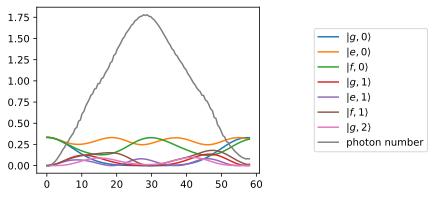

In [40]:
# resonator decay constant
kappa = 0.003
#
superposition012 = 1/np.sqrt(3)*qutip.basis(total_truncation, hilbertspace.dressed_index((0,0)))\
                   +1/np.sqrt(3)*qutip.basis(total_truncation, hilbertspace.dressed_index((1,0)))\
                   +1/np.sqrt(3)*qutip.basis(total_truncation, hilbertspace.dressed_index((2,0)))
result = qutip.mesolve(
    H = H_with_drive,
    rho0 = superposition012,
    tlist = tlist,
    e_ops=[state * state.dag() for state in qutip_states]+[a.dag()*a],
    # c_ops=[np.sqrt(kappa) * a],
    options=qutip.Options(store_final_state=True),
    progress_bar = True
)
fig, ax1 = plt.subplots(1, 1, figsize=(4, 3))


for idx, res in zip(idxs, result.expect):
    product_state = product_states[idxs.index(idx)]
    qubit_state = dictionary[product_state[0]]
    resonator_state = product_state[1]
    ax1.plot(tlist, res, label=r"$|%s\rangle$" % (str(",".join([qubit_state,str(resonator_state)]))))
ax1.plot(tlist, result.expect[-1], label=r"photon number")
ax1.legend(loc='center', ncol=1, bbox_to_anchor=(1.5, 0.5))

plt.show()